### Introduction
In the case of 'Unfair clauses' the data is retrieved using the 'datasets' library.

In [53]:
# Required imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns

# Data processing
from datasets import load_dataset

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Data cleaning

• Remove: capital letters, punctuation, numbers, stop words

• Stemming 

• Correct misspellings

• Parts of speech tagging

• Chunking (named entity recognition, compound term extraction)

In [2]:
# Retrieving data using load_dataset function
data = load_dataset("laugustyniak/abusive-clauses-pl")
print(data)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4284
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3453
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1519
    })
})


The data is divided into sets: train, test and validation.

In [3]:
# Transforming data to Pandas DataFrame
df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()
df_validation = data['validation'].to_pandas()

In [4]:
df_train.head(10)

,text,label
0,Wszelka korespondencja wysyłana przez Pożyczko...,0
1,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,0
2,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,0
3,Pożyczkobiorca zleca firmie Narodowy Fundusz P...,0
4,Od niespłaconej w terminie raty Pożyczkobiorca...,0
5,Pożyczkobiorca ma prawo wybrać inny sposób prz...,0
6,W przypadku braku spłaty pożyczki w terminie P...,0
7,Zabezpieczeniem spłaty pożyczki będzie podpisa...,0
8,Termin zwrotu pożyczki strony ustalają na 01 w...,0
9,"Okres trwania pożyczki wynosi 1 miesiąc, przy ...",0


In [5]:
print(df_train['text'][9])

Okres trwania pożyczki wynosi 1 miesiąc, przy czym może zostać przedłużana co miesiąc do 24 miesięcy


In the 'text' column there is text of agreement. In the 'label' (output) column there are two possible values: 0 in the case of abusive clause\, and 1 in the case of correct agreement statement

In [6]:
# Checking if there are any null values in the 'text' column of the train, test, or validation
print(df_train['text'].isnull().any() or df_test['text'].isnull().any() or df_validation['text'].isnull().any())

False


In [38]:
# Percentage of abusive clauses and correct agreement statements + visualization
abusive_percentage = round(df_train['label'].value_counts()[0] / len(df_train['label']) * 100, 2)
correct_percentage = round(df_train['label'].value_counts()[1] / len(df_train['label']) * 100, 2)
print(f"In train dataset:")
print(f"{abusive_percentage}% of agreements are considered abusive")
print(f"{correct_percentage}% of agreements are considered correct")

In train dataset:
45.42% of agreements are abusive
54.58% of agreements are correct


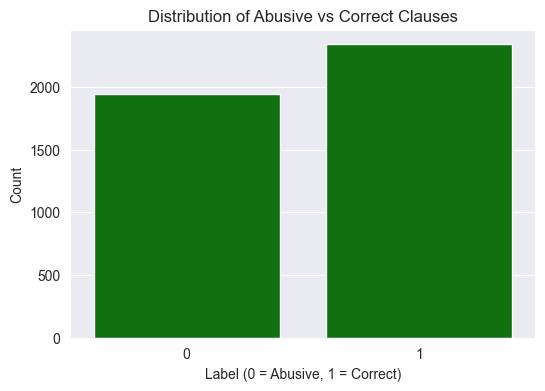

In [35]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_train, color='green')
plt.title('Distribution of abusive and correct clauses')
plt.xlabel('Label (0 = abusive, 1 = Correct)')
plt.ylabel('Count')
plt.show()

In [39]:
# Calculating the length of each agreement + visualization
df_train['text_length'] = df_train['text'].apply(len)

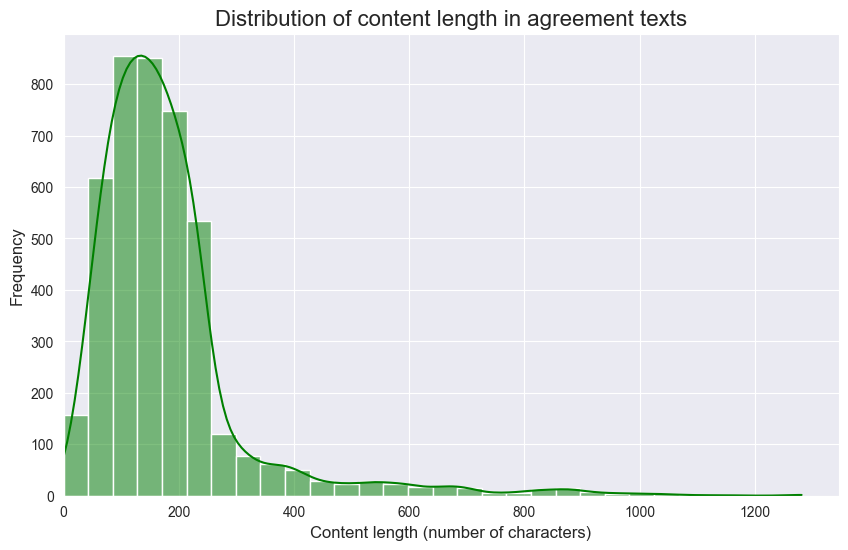

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], kde=True, bins=30, color='green')
plt.title('Distribution of content length in agreement texts', fontsize=16)
plt.xlabel('Content length (number of characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(left=0)
plt.show()

From the chart it can be concluded that most of the content of the agreements does not exceed 200 characters.

## 2. Data preprocessing

short description

In [10]:
df_train['text'].iloc[9]

'Okres trwania pożyczki wynosi 1 miesiąc, przy czym może zostać przedłużana co miesiąc do 24 miesięcy'

In [11]:
# Removing numbers from the text using regex pattern
pattern = r'\b\w*\d\w*\b'
df_train['text'] = df_train['text'].str.replace(pattern, '', regex=True).str.strip()
df_train['text'].iloc[9]

'Okres trwania pożyczki wynosi  miesiąc, przy czym może zostać przedłużana co miesiąc do  miesięcy'

In [12]:
# Removing capital letters from the content
df_train['text'] = df_train['text'].str.lower()
df_train['text'].iloc[9]

'okres trwania pożyczki wynosi  miesiąc, przy czym może zostać przedłużana co miesiąc do  miesięcy'

In [13]:
# Removing punctuation marks from the content
df_train['text'] = df_train['text'].str.replace(r'[^\w\s]','',regex=True)
df_train['text'].iloc[9]

'okres trwania pożyczki wynosi  miesiąc przy czym może zostać przedłużana co miesiąc do  miesięcy'

In [ ]:
# Data preprocessing for test and validation data sets the same way as the training data to ensure consistency in how the model sees the data
df_test['text'] = df_test['text'].str.replace(pattern, '', regex=True).str.strip()
df_test['text'] = df_test['text'].str.lower()
df_test['text'] = df_test['text'].str.replace(r'[^\w\s]','',regex=True)

df_validation['text'] = df_validation['text'].str.replace(pattern, '', regex=True).str.strip()
df_validation['text'] = df_validation['text'].str.lower()
df_validation['text'] = df_validation['text'].str.replace(r'[^\w\s]','',regex=True)

## Machine learning

In [15]:
x_train = df_train.text
x_test = df_test.text

In [16]:
y_train = df_train.label
y_test = df_test.label

There are no polish stop words in nltk library, so I manually added txt file with them

In [17]:
# Loading stop words from a file
with open("polish.stopwords.txt", "r", encoding="utf-8") as f:
    polish_stop_words = [line.strip() for line in f]

In [18]:
cv = CountVectorizer(stop_words=polish_stop_words)
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

In [19]:
cv_tfidf = TfidfVectorizer(stop_words=polish_stop_words)
x_train_cv_tfidf = cv_tfidf.fit_transform(x_train)
x_test_cv_tfidf = cv_tfidf.transform(x_test)

### Linear regression

In [20]:
# Linear regression classification model
lr = LogisticRegression()
lr.fit(x_train_cv, y_train)
y_pred_cv = lr.predict(x_test_cv)

In [21]:
# Logistic regression model evaluation
cm = confusion_matrix(y_test, y_pred_cv)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.799
Precision: 0.853
Recall: 0.848
F1 Score: 0.85


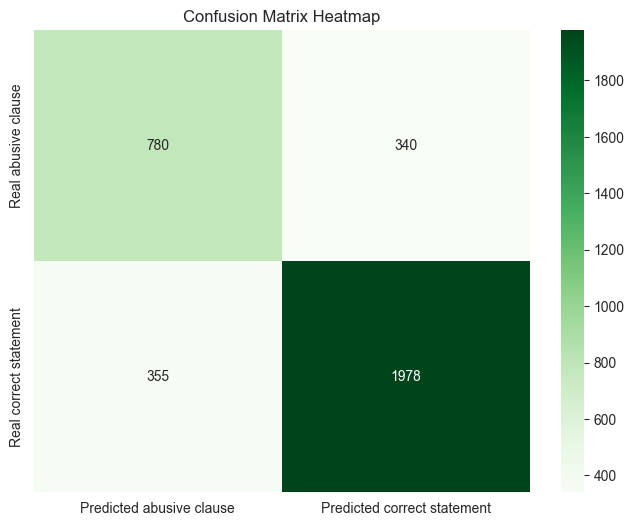

In [22]:
# Visualization of evaluation
plt.figure(figsize=(8, 6))
true_labels = ['Real abusive clause', 'Real correct statement']
predicted_labels = ['Predicted abusive clause', 'Predicted correct statement']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=predicted_labels, yticklabels=true_labels)
plt.title('Confusion Matrix Heatmap')
plt.show()

In [23]:
# Logistic regression with TF-IDF vectorizer
lr2 = LogisticRegression()
lr2.fit(x_train_cv_tfidf, y_train)
y_pred_tfidf = lr2.predict(x_test_cv_tfidf)

In [24]:
# Model evaluation
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.799
Precision: 0.853
Recall: 0.848
F1 Score: 0.85


### Naive bayes

In [25]:
nb = MultinomialNB()
nb.fit(x_train_cv, y_train)
y_pred_cv_nb = nb.predict(x_test_cv)

MultinomialNB()

In [27]:
# Model evaluation
cm = confusion_matrix(y_test, y_pred_cv_nb)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.775
Precision: 0.867
Recall: 0.787
F1 Score: 0.825


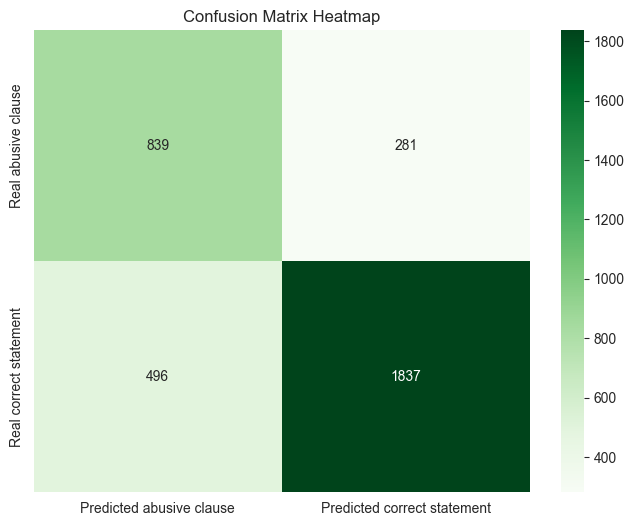

In [28]:
# Visualization of evaluation
plt.figure(figsize=(8, 6))
true_labels = ['Real abusive clause', 'Real correct statement']
predicted_labels = ['Predicted abusive clause', 'Predicted correct statement']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=predicted_labels, yticklabels=true_labels)
plt.title('Confusion Matrix Heatmap')
plt.show()

## Support Vector Machine (SVM)

In [ ]:
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(x_train_cv, y_train)
y_pred_svm = svm_model.predict(x_test_cv)

In [50]:
# Model evaluation
cm = confusion_matrix(y_test, y_pred_svm)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.785
Precision: 0.858
Recall: 0.818
F1 Score: 0.838


## K-Nearest Neighbors (KNN)

In [51]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_cv, y_train)
y_pred_knn = knn_model.predict(x_test_cv)

In [52]:
cm = confusion_matrix(y_test, y_pred_svm)
true_neg, false_pos = cm[0, 0], cm[0, 1]
false_neg, true_pos = cm[1, 0], cm[1, 1]

accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg), 3)
precision = round(true_pos / (true_pos + false_pos), 3)
recall = round(true_pos / (true_pos + false_neg), 3)
f1 = round(2 * (precision * recall) / (precision + recall), 3)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.785
Precision: 0.858
Recall: 0.818
F1 Score: 0.838


# Summary

The goal of this project was to create a model for classifying agreement contents into two categories: abusive clauses and correct contractual statements, by:

• Data Preparation:

Data was retrieved from a dataset available in the datasets library.
Initial preprocessing included the removal of digits, capital letters, punctuation marks, and stop words.

• Text Processing:

Different approaches to vectorization were used: CountVectorizer and TfidfVectorizer, with Polish stop words taken into account.

• Model Training:

A few classification models were trained and included in report. All of them were tested on the test dataset.


Model performance was evaluated using metrics such as accuracy, precision, recall, and F1-score, with results displayed in a confusion matrix. The results of the models' evaluations and classifications were presented in visualizations, including confusion matrices.

The maximum F1 score that was achieved was 0.852 for Linear Regression model, both for CountVectorizer and TfidfVectorizer. All other models had a worse F1 score.

A difficulty encountered in the project was the lack of libraries for natural language processing in Polish, which made lemmetization and stemming impossible or very time-consuming.
